# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|█████████████| 60.0k/60.0k [03:26<00:00, 290File/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

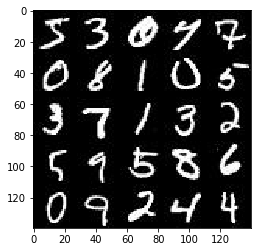

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

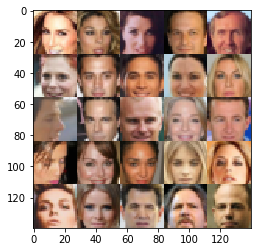

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.12.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], "real_input")
    z_input = tf.placeholder(tf.float32, [None, z_dim], "z_input")
    learning_rate = tf.placeholder(tf.float32, None, "learning_rate")

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [14]:
alpha = 0.2

def leaky_relu(x):
    return tf.maximum(alpha * x, x)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
                        
        l1 = tf.layers.conv2d(images, 64, 5, 2, 'same')
        l1 = leaky_relu(l1) 
        
        l2 = tf.layers.conv2d(l1, 128, 5, 2, 'same')
        l2 = tf.layers.batch_normalization(l2, training=True)
        l2 = leaky_relu(l2)
        
        l3 = tf.layers.conv2d(l2, 256, 5, 2, 'same')
        l3 = tf.layers.batch_normalization(l3, training=True)
        l3 = leaky_relu(l3)
        
        flat = tf.reshape(l3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope("generator", reuse=not is_train):
        
        l1 = tf.layers.dense(z, 7 * 7 * 512)
        l1 = tf.reshape(l1, (-1, 7, 7, 512))
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = leaky_relu(l1)
        
        l2 = tf.layers.conv2d_transpose(l1, 256, 5, 1, 'SAME')
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = leaky_relu(l2)
        
        l3 = tf.layers.conv2d_transpose(l2, 128, 5, 2, 'SAME')
        l3 = tf.layers.batch_normalization(l3, training=is_train)
        l3 = leaky_relu(l3)
    
        logits = tf.layers.conv2d_transpose(l3, out_channel_dim, 5, 2, 'SAME')
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [16]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    gen_model = generator(input_z, out_channel_dim)
    disc_model_real, disc_logits_real = discriminator(input_real)
    disc_model_fake, disc_logits_fake = discriminator(gen_model, reuse=True)

    disc_loss_real = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits = disc_logits_real, labels = tf.ones_like(disc_logits_real) * alpha) )
    disc_loss_fake = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits = disc_logits_fake, labels = tf.zeros_like(disc_logits_fake)) )
    disc_loss = disc_loss_real + disc_loss_fake
        
    gen_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, labels=tf.ones_like(disc_logits_fake)) )
 
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    all_vars = tf.trainable_variables()
    disc_vars = [var for var in all_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in all_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list = disc_vars)
        gen_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list = gen_vars)
    return disc_opt, gen_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [28]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, data_shape[3])
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(disc_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(gen_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_disc = disc_loss.eval( {input_real: batch_images, input_z: batch_z} )
                    train_loss_gen = gen_loss.eval( {input_z: batch_z} )

                    print(f"Epoch {epoch+1} of {epochs}",
                          f"Batch {steps}",
                          f"Discriminator Loss: {train_loss_disc}",
                          f"Generator Loss: {train_loss_gen}")

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1 of 2 Batch 10 Discriminator Loss: 0.9218772649765015 Generator Loss: 8.777902603149414
Epoch 1 of 2 Batch 20 Discriminator Loss: 0.6343985199928284 Generator Loss: 3.379384994506836
Epoch 1 of 2 Batch 30 Discriminator Loss: 0.7135753631591797 Generator Loss: 2.184626579284668
Epoch 1 of 2 Batch 40 Discriminator Loss: 0.693473219871521 Generator Loss: 2.8418891429901123
Epoch 1 of 2 Batch 50 Discriminator Loss: 0.626983642578125 Generator Loss: 2.766655921936035
Epoch 1 of 2 Batch 60 Discriminator Loss: 0.6429398655891418 Generator Loss: 3.2172436714172363
Epoch 1 of 2 Batch 70 Discriminator Loss: 1.6404130458831787 Generator Loss: 7.970424652099609
Epoch 1 of 2 Batch 80 Discriminator Loss: 0.6139933466911316 Generator Loss: 2.786752939224243
Epoch 1 of 2 Batch 90 Discriminator Loss: 0.6135954260826111 Generator Loss: 2.6453022956848145
Epoch 1 of 2 Batch 100 Discriminator Loss: 0.6413768529891968 Generator Loss: 3.054638624191284


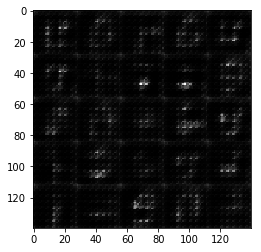

Epoch 1 of 2 Batch 110 Discriminator Loss: 0.666121244430542 Generator Loss: 2.085326671600342
Epoch 1 of 2 Batch 120 Discriminator Loss: 0.6406401991844177 Generator Loss: 2.5443382263183594
Epoch 1 of 2 Batch 130 Discriminator Loss: 0.626301646232605 Generator Loss: 2.3473756313323975
Epoch 1 of 2 Batch 140 Discriminator Loss: 0.6707873940467834 Generator Loss: 2.2513904571533203
Epoch 1 of 2 Batch 150 Discriminator Loss: 0.6759673953056335 Generator Loss: 2.4657483100891113
Epoch 1 of 2 Batch 160 Discriminator Loss: 0.6558154821395874 Generator Loss: 2.3218588829040527
Epoch 1 of 2 Batch 170 Discriminator Loss: 0.6335304975509644 Generator Loss: 2.663989305496216
Epoch 1 of 2 Batch 180 Discriminator Loss: 0.6562600135803223 Generator Loss: 2.5607190132141113
Epoch 1 of 2 Batch 190 Discriminator Loss: 0.6473767757415771 Generator Loss: 2.350475311279297
Epoch 1 of 2 Batch 200 Discriminator Loss: 0.6823897957801819 Generator Loss: 3.388681411743164


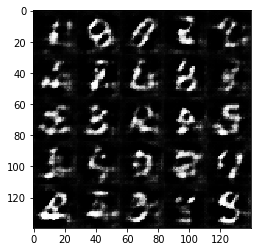

Epoch 1 of 2 Batch 210 Discriminator Loss: 0.6380974650382996 Generator Loss: 2.863135576248169
Epoch 1 of 2 Batch 220 Discriminator Loss: 0.7890051007270813 Generator Loss: 1.6414786577224731
Epoch 1 of 2 Batch 230 Discriminator Loss: 0.6673641204833984 Generator Loss: 2.3594961166381836
Epoch 1 of 2 Batch 240 Discriminator Loss: 0.6935652494430542 Generator Loss: 2.0275096893310547
Epoch 1 of 2 Batch 250 Discriminator Loss: 0.6280676126480103 Generator Loss: 2.52252197265625
Epoch 1 of 2 Batch 260 Discriminator Loss: 0.6619913578033447 Generator Loss: 2.0928521156311035
Epoch 1 of 2 Batch 270 Discriminator Loss: 0.6244721412658691 Generator Loss: 2.5678532123565674
Epoch 1 of 2 Batch 280 Discriminator Loss: 0.6756502389907837 Generator Loss: 2.0421814918518066
Epoch 1 of 2 Batch 290 Discriminator Loss: 0.6836569309234619 Generator Loss: 1.9270004034042358
Epoch 1 of 2 Batch 300 Discriminator Loss: 0.6330636739730835 Generator Loss: 2.26910138130188


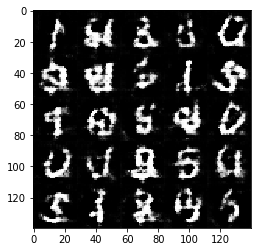

Epoch 1 of 2 Batch 310 Discriminator Loss: 0.644446611404419 Generator Loss: 2.513343334197998
Epoch 1 of 2 Batch 320 Discriminator Loss: 0.6525387763977051 Generator Loss: 2.1375365257263184
Epoch 1 of 2 Batch 330 Discriminator Loss: 0.6495184898376465 Generator Loss: 3.0000922679901123
Epoch 1 of 2 Batch 340 Discriminator Loss: 0.6875423192977905 Generator Loss: 1.8947452306747437
Epoch 1 of 2 Batch 350 Discriminator Loss: 0.7281453013420105 Generator Loss: 3.761647939682007
Epoch 1 of 2 Batch 360 Discriminator Loss: 0.6428508162498474 Generator Loss: 2.2374377250671387
Epoch 1 of 2 Batch 370 Discriminator Loss: 0.6429697275161743 Generator Loss: 2.6403093338012695
Epoch 1 of 2 Batch 380 Discriminator Loss: 0.6268131136894226 Generator Loss: 2.6460824012756348
Epoch 1 of 2 Batch 390 Discriminator Loss: 0.6646139025688171 Generator Loss: 2.7657392024993896
Epoch 1 of 2 Batch 400 Discriminator Loss: 0.6799300909042358 Generator Loss: 2.055417537689209


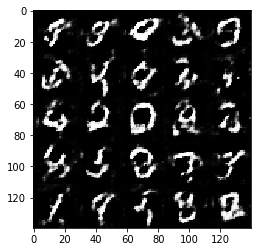

Epoch 1 of 2 Batch 410 Discriminator Loss: 0.6361809968948364 Generator Loss: 2.3596763610839844
Epoch 1 of 2 Batch 420 Discriminator Loss: 0.6316319704055786 Generator Loss: 2.7145872116088867
Epoch 1 of 2 Batch 430 Discriminator Loss: 0.6488181948661804 Generator Loss: 2.2170515060424805
Epoch 1 of 2 Batch 440 Discriminator Loss: 0.63033127784729 Generator Loss: 2.5767405033111572
Epoch 1 of 2 Batch 450 Discriminator Loss: 0.6304805278778076 Generator Loss: 2.690088987350464
Epoch 1 of 2 Batch 460 Discriminator Loss: 0.652747631072998 Generator Loss: 2.265782594680786
Epoch 1 of 2 Batch 470 Discriminator Loss: 0.6437124013900757 Generator Loss: 2.2615203857421875
Epoch 1 of 2 Batch 480 Discriminator Loss: 0.6669368147850037 Generator Loss: 2.129652738571167
Epoch 1 of 2 Batch 490 Discriminator Loss: 0.6422827243804932 Generator Loss: 2.1820554733276367
Epoch 1 of 2 Batch 500 Discriminator Loss: 0.6288579106330872 Generator Loss: 2.290358066558838


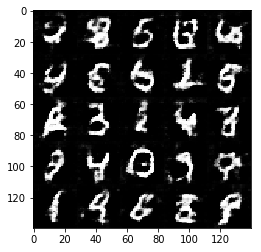

Epoch 1 of 2 Batch 510 Discriminator Loss: 0.6859626173973083 Generator Loss: 2.9933784008026123
Epoch 1 of 2 Batch 520 Discriminator Loss: 0.637508749961853 Generator Loss: 2.250500202178955
Epoch 1 of 2 Batch 530 Discriminator Loss: 0.6649755835533142 Generator Loss: 3.103691577911377
Epoch 1 of 2 Batch 540 Discriminator Loss: 0.6245020627975464 Generator Loss: 2.687535285949707
Epoch 1 of 2 Batch 550 Discriminator Loss: 0.6172753572463989 Generator Loss: 2.6596531867980957
Epoch 1 of 2 Batch 560 Discriminator Loss: 0.652321457862854 Generator Loss: 2.2575576305389404
Epoch 1 of 2 Batch 570 Discriminator Loss: 0.6774502992630005 Generator Loss: 2.0272700786590576
Epoch 1 of 2 Batch 580 Discriminator Loss: 0.6480399370193481 Generator Loss: 2.1484060287475586
Epoch 1 of 2 Batch 590 Discriminator Loss: 0.6432764530181885 Generator Loss: 2.129500389099121
Epoch 1 of 2 Batch 600 Discriminator Loss: 0.6394299268722534 Generator Loss: 2.2586684226989746


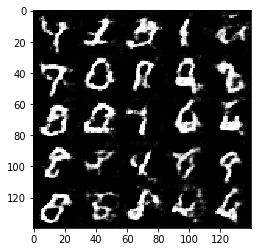

Epoch 1 of 2 Batch 610 Discriminator Loss: 0.6464211940765381 Generator Loss: 2.1222527027130127
Epoch 1 of 2 Batch 620 Discriminator Loss: 0.646100640296936 Generator Loss: 2.1679444313049316
Epoch 1 of 2 Batch 630 Discriminator Loss: 0.660651445388794 Generator Loss: 2.0370023250579834
Epoch 1 of 2 Batch 640 Discriminator Loss: 0.6313093304634094 Generator Loss: 2.4416608810424805
Epoch 1 of 2 Batch 650 Discriminator Loss: 0.6533312797546387 Generator Loss: 2.1448354721069336
Epoch 1 of 2 Batch 660 Discriminator Loss: 0.6650201678276062 Generator Loss: 2.186049699783325
Epoch 1 of 2 Batch 670 Discriminator Loss: 0.6746746897697449 Generator Loss: 3.2251877784729004
Epoch 1 of 2 Batch 680 Discriminator Loss: 0.6694281697273254 Generator Loss: 2.072319984436035
Epoch 1 of 2 Batch 690 Discriminator Loss: 0.6473867893218994 Generator Loss: 2.11411190032959
Epoch 1 of 2 Batch 700 Discriminator Loss: 0.6511987447738647 Generator Loss: 2.1476006507873535


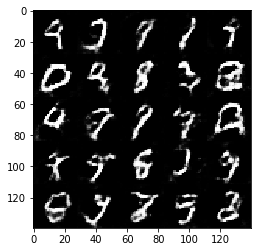

Epoch 1 of 2 Batch 710 Discriminator Loss: 0.6414900422096252 Generator Loss: 2.4157369136810303
Epoch 1 of 2 Batch 720 Discriminator Loss: 0.6403074860572815 Generator Loss: 2.4700846672058105
Epoch 1 of 2 Batch 730 Discriminator Loss: 0.6413196921348572 Generator Loss: 2.3585877418518066
Epoch 1 of 2 Batch 740 Discriminator Loss: 0.6393498182296753 Generator Loss: 2.908019542694092
Epoch 1 of 2 Batch 750 Discriminator Loss: 0.6870771646499634 Generator Loss: 3.2593955993652344
Epoch 1 of 2 Batch 760 Discriminator Loss: 0.6514824628829956 Generator Loss: 2.095057964324951
Epoch 1 of 2 Batch 770 Discriminator Loss: 0.659095287322998 Generator Loss: 2.024237632751465
Epoch 1 of 2 Batch 780 Discriminator Loss: 0.6359929442405701 Generator Loss: 2.249260663986206
Epoch 1 of 2 Batch 790 Discriminator Loss: 0.6417078375816345 Generator Loss: 2.7008936405181885
Epoch 1 of 2 Batch 800 Discriminator Loss: 0.6300159096717834 Generator Loss: 2.5699844360351562


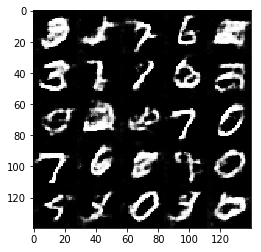

Epoch 1 of 2 Batch 810 Discriminator Loss: 0.6327021718025208 Generator Loss: 2.352093458175659
Epoch 1 of 2 Batch 820 Discriminator Loss: 0.6311782598495483 Generator Loss: 2.7392170429229736
Epoch 1 of 2 Batch 830 Discriminator Loss: 0.6337273716926575 Generator Loss: 2.735836982727051
Epoch 1 of 2 Batch 840 Discriminator Loss: 0.5988507270812988 Generator Loss: 2.702537775039673
Epoch 1 of 2 Batch 850 Discriminator Loss: 0.9628670811653137 Generator Loss: 5.316234588623047
Epoch 1 of 2 Batch 860 Discriminator Loss: 0.6402079463005066 Generator Loss: 2.6681509017944336
Epoch 1 of 2 Batch 870 Discriminator Loss: 0.680377185344696 Generator Loss: 2.00651216506958
Epoch 1 of 2 Batch 880 Discriminator Loss: 0.6261026859283447 Generator Loss: 2.539618968963623
Epoch 1 of 2 Batch 890 Discriminator Loss: 0.6258324384689331 Generator Loss: 2.504307985305786
Epoch 1 of 2 Batch 900 Discriminator Loss: 0.6200422048568726 Generator Loss: 2.5092616081237793


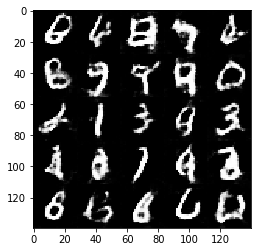

Epoch 1 of 2 Batch 910 Discriminator Loss: 0.6245031356811523 Generator Loss: 2.41318416595459
Epoch 1 of 2 Batch 920 Discriminator Loss: 0.6289970874786377 Generator Loss: 2.3214120864868164
Epoch 1 of 2 Batch 930 Discriminator Loss: 0.6289985179901123 Generator Loss: 2.473844051361084
Epoch 2 of 2 Batch 10 Discriminator Loss: 0.6664906144142151 Generator Loss: 1.9646844863891602
Epoch 2 of 2 Batch 20 Discriminator Loss: 0.6585330963134766 Generator Loss: 2.8133950233459473
Epoch 2 of 2 Batch 30 Discriminator Loss: 0.6391745805740356 Generator Loss: 2.3057169914245605
Epoch 2 of 2 Batch 40 Discriminator Loss: 0.6275596022605896 Generator Loss: 2.603813648223877
Epoch 2 of 2 Batch 50 Discriminator Loss: 0.618103563785553 Generator Loss: 2.5157909393310547
Epoch 2 of 2 Batch 60 Discriminator Loss: 0.6816282272338867 Generator Loss: 3.0661396980285645
Epoch 2 of 2 Batch 70 Discriminator Loss: 0.6330790519714355 Generator Loss: 2.2546653747558594
Epoch 2 of 2 Batch 80 Discriminator Loss: 

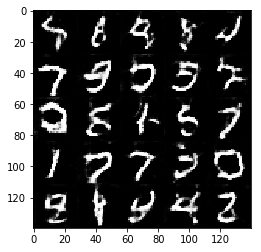

Epoch 2 of 2 Batch 110 Discriminator Loss: 0.6509933471679688 Generator Loss: 2.086793899536133
Epoch 2 of 2 Batch 120 Discriminator Loss: 0.6332986950874329 Generator Loss: 2.304196834564209
Epoch 2 of 2 Batch 130 Discriminator Loss: 0.6517560482025146 Generator Loss: 3.1813535690307617
Epoch 2 of 2 Batch 140 Discriminator Loss: 0.6867965459823608 Generator Loss: 1.9248120784759521
Epoch 2 of 2 Batch 150 Discriminator Loss: 0.682844877243042 Generator Loss: 1.9368884563446045
Epoch 2 of 2 Batch 160 Discriminator Loss: 0.6754862070083618 Generator Loss: 3.26409912109375
Epoch 2 of 2 Batch 170 Discriminator Loss: 1.0565489530563354 Generator Loss: 5.458644866943359
Epoch 2 of 2 Batch 180 Discriminator Loss: 0.6822096705436707 Generator Loss: 2.1415176391601562
Epoch 2 of 2 Batch 190 Discriminator Loss: 0.6425767540931702 Generator Loss: 2.4698407649993896
Epoch 2 of 2 Batch 200 Discriminator Loss: 0.6386459469795227 Generator Loss: 2.415541172027588


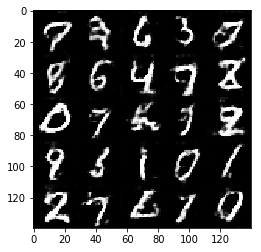

Epoch 2 of 2 Batch 210 Discriminator Loss: 0.6119312047958374 Generator Loss: 2.650660991668701
Epoch 2 of 2 Batch 220 Discriminator Loss: 0.6418757438659668 Generator Loss: 2.229133129119873
Epoch 2 of 2 Batch 230 Discriminator Loss: 0.6255792379379272 Generator Loss: 2.3714892864227295
Epoch 2 of 2 Batch 240 Discriminator Loss: 0.6439027786254883 Generator Loss: 2.1677117347717285
Epoch 2 of 2 Batch 250 Discriminator Loss: 0.617579460144043 Generator Loss: 2.4189553260803223
Epoch 2 of 2 Batch 260 Discriminator Loss: 0.6245163083076477 Generator Loss: 2.571659564971924
Epoch 2 of 2 Batch 270 Discriminator Loss: 0.6342496871948242 Generator Loss: 2.382966995239258
Epoch 2 of 2 Batch 280 Discriminator Loss: 0.6490494012832642 Generator Loss: 2.2205615043640137
Epoch 2 of 2 Batch 290 Discriminator Loss: 0.6376023888587952 Generator Loss: 2.252976894378662
Epoch 2 of 2 Batch 300 Discriminator Loss: 0.6220422387123108 Generator Loss: 2.3385322093963623


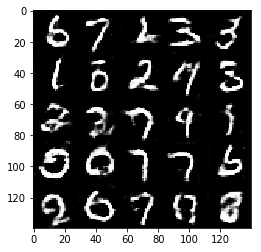

Epoch 2 of 2 Batch 310 Discriminator Loss: 0.6484695076942444 Generator Loss: 3.0458216667175293
Epoch 2 of 2 Batch 320 Discriminator Loss: 0.6452487707138062 Generator Loss: 2.1779210567474365
Epoch 2 of 2 Batch 330 Discriminator Loss: 0.6461471915245056 Generator Loss: 2.938868999481201
Epoch 2 of 2 Batch 340 Discriminator Loss: 0.6642223596572876 Generator Loss: 2.4131531715393066
Epoch 2 of 2 Batch 350 Discriminator Loss: 0.618941605091095 Generator Loss: 2.578603744506836
Epoch 2 of 2 Batch 360 Discriminator Loss: 0.6392800807952881 Generator Loss: 2.305752754211426
Epoch 2 of 2 Batch 370 Discriminator Loss: 0.6437744498252869 Generator Loss: 2.1456103324890137
Epoch 2 of 2 Batch 380 Discriminator Loss: 0.607806921005249 Generator Loss: 2.59175968170166
Epoch 2 of 2 Batch 390 Discriminator Loss: 0.6151818633079529 Generator Loss: 2.57728910446167
Epoch 2 of 2 Batch 400 Discriminator Loss: 0.6305395364761353 Generator Loss: 2.264261245727539


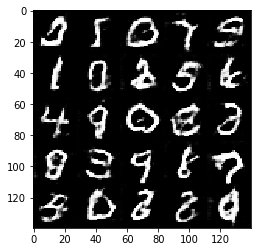

Epoch 2 of 2 Batch 410 Discriminator Loss: 0.6226150989532471 Generator Loss: 2.5534465312957764
Epoch 2 of 2 Batch 420 Discriminator Loss: 0.7020541429519653 Generator Loss: 1.795343041419983
Epoch 2 of 2 Batch 430 Discriminator Loss: 0.6222977638244629 Generator Loss: 2.495931625366211
Epoch 2 of 2 Batch 440 Discriminator Loss: 0.6173955798149109 Generator Loss: 2.370087146759033
Epoch 2 of 2 Batch 450 Discriminator Loss: 0.6441610455513 Generator Loss: 3.3455142974853516
Epoch 2 of 2 Batch 460 Discriminator Loss: 0.6302737593650818 Generator Loss: 2.2830846309661865
Epoch 2 of 2 Batch 470 Discriminator Loss: 0.641659677028656 Generator Loss: 2.2475967407226562
Epoch 2 of 2 Batch 480 Discriminator Loss: 0.6291706562042236 Generator Loss: 2.3005659580230713
Epoch 2 of 2 Batch 490 Discriminator Loss: 0.6403944492340088 Generator Loss: 2.2650866508483887
Epoch 2 of 2 Batch 500 Discriminator Loss: 0.6448408365249634 Generator Loss: 2.11032772064209


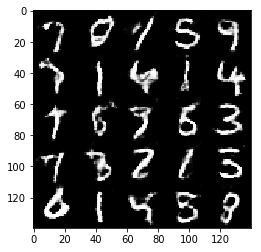

Epoch 2 of 2 Batch 510 Discriminator Loss: 0.7131655216217041 Generator Loss: 3.5983104705810547
Epoch 2 of 2 Batch 520 Discriminator Loss: 0.6279436349868774 Generator Loss: 2.6028761863708496
Epoch 2 of 2 Batch 530 Discriminator Loss: 0.6417871117591858 Generator Loss: 2.171597719192505
Epoch 2 of 2 Batch 540 Discriminator Loss: 0.6151534914970398 Generator Loss: 2.497640371322632
Epoch 2 of 2 Batch 550 Discriminator Loss: 0.6159707307815552 Generator Loss: 2.665876865386963
Epoch 2 of 2 Batch 560 Discriminator Loss: 0.679747462272644 Generator Loss: 1.920044183731079
Epoch 2 of 2 Batch 570 Discriminator Loss: 0.7109477519989014 Generator Loss: 3.3276023864746094
Epoch 2 of 2 Batch 580 Discriminator Loss: 0.6238819360733032 Generator Loss: 2.420734405517578
Epoch 2 of 2 Batch 590 Discriminator Loss: 0.6384155750274658 Generator Loss: 2.176347494125366
Epoch 2 of 2 Batch 600 Discriminator Loss: 0.6196985840797424 Generator Loss: 2.332291603088379


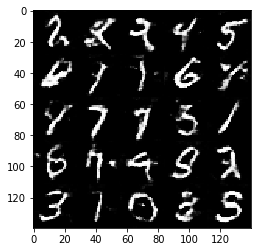

Epoch 2 of 2 Batch 610 Discriminator Loss: 0.6162542104721069 Generator Loss: 2.625418186187744
Epoch 2 of 2 Batch 620 Discriminator Loss: 0.6675991415977478 Generator Loss: 3.119873046875
Epoch 2 of 2 Batch 630 Discriminator Loss: 0.6239653825759888 Generator Loss: 2.4069652557373047
Epoch 2 of 2 Batch 640 Discriminator Loss: 0.6142929792404175 Generator Loss: 2.753810167312622
Epoch 2 of 2 Batch 650 Discriminator Loss: 0.6251134872436523 Generator Loss: 2.4195518493652344
Epoch 2 of 2 Batch 660 Discriminator Loss: 0.6159971952438354 Generator Loss: 2.72957181930542
Epoch 2 of 2 Batch 670 Discriminator Loss: 0.6604969501495361 Generator Loss: 1.999683141708374
Epoch 2 of 2 Batch 680 Discriminator Loss: 0.6346472501754761 Generator Loss: 2.3649916648864746
Epoch 2 of 2 Batch 690 Discriminator Loss: 0.6194267868995667 Generator Loss: 2.7506182193756104
Epoch 2 of 2 Batch 700 Discriminator Loss: 0.7004473805427551 Generator Loss: 1.8261573314666748


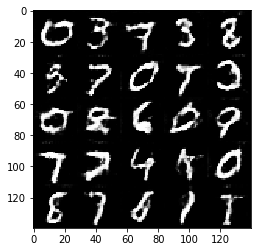

Epoch 2 of 2 Batch 710 Discriminator Loss: 0.6257414817810059 Generator Loss: 2.311107873916626
Epoch 2 of 2 Batch 720 Discriminator Loss: 0.637599766254425 Generator Loss: 2.197171688079834
Epoch 2 of 2 Batch 730 Discriminator Loss: 0.6803884506225586 Generator Loss: 3.4904825687408447
Epoch 2 of 2 Batch 740 Discriminator Loss: 0.6067489981651306 Generator Loss: 2.497828960418701
Epoch 2 of 2 Batch 750 Discriminator Loss: 0.6163666248321533 Generator Loss: 2.499825954437256
Epoch 2 of 2 Batch 760 Discriminator Loss: 0.611746609210968 Generator Loss: 2.361827850341797
Epoch 2 of 2 Batch 770 Discriminator Loss: 0.5973069667816162 Generator Loss: 2.669365167617798
Epoch 2 of 2 Batch 780 Discriminator Loss: 0.6198412179946899 Generator Loss: 2.623415470123291
Epoch 2 of 2 Batch 790 Discriminator Loss: 0.6433169841766357 Generator Loss: 2.1559109687805176
Epoch 2 of 2 Batch 800 Discriminator Loss: 1.395064353942871 Generator Loss: 4.171528339385986


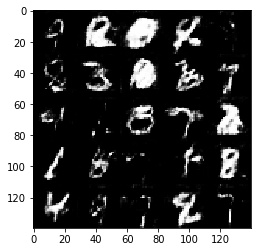

Epoch 2 of 2 Batch 810 Discriminator Loss: 0.6555257439613342 Generator Loss: 2.3144924640655518
Epoch 2 of 2 Batch 820 Discriminator Loss: 0.6143941283226013 Generator Loss: 2.407911539077759
Epoch 2 of 2 Batch 830 Discriminator Loss: 0.6557384729385376 Generator Loss: 2.2671279907226562
Epoch 2 of 2 Batch 840 Discriminator Loss: 0.6334297060966492 Generator Loss: 2.5667994022369385
Epoch 2 of 2 Batch 850 Discriminator Loss: 0.6414555311203003 Generator Loss: 2.431548595428467
Epoch 2 of 2 Batch 860 Discriminator Loss: 0.6381733417510986 Generator Loss: 2.572882652282715
Epoch 2 of 2 Batch 870 Discriminator Loss: 0.6654331684112549 Generator Loss: 2.22062611579895
Epoch 2 of 2 Batch 880 Discriminator Loss: 0.6373940110206604 Generator Loss: 2.2589588165283203
Epoch 2 of 2 Batch 890 Discriminator Loss: 0.6386579871177673 Generator Loss: 2.4825820922851562
Epoch 2 of 2 Batch 900 Discriminator Loss: 0.633115291595459 Generator Loss: 2.39927077293396


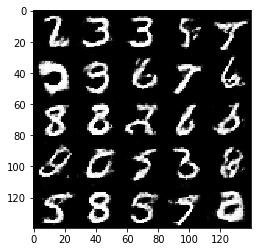

Epoch 2 of 2 Batch 910 Discriminator Loss: 0.6371726989746094 Generator Loss: 2.2590460777282715
Epoch 2 of 2 Batch 920 Discriminator Loss: 0.6441457867622375 Generator Loss: 2.2307071685791016
Epoch 2 of 2 Batch 930 Discriminator Loss: 0.6321641206741333 Generator Loss: 2.4395604133605957


In [35]:


batch_size = 64 # Tried with 32, 64, 128
z_dim = 128
learning_rate = 0.001 # Tried with 0.01, 0.001 and 0.003
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1 of 1 Batch 10 Discriminator Loss: 1.4320875406265259 Generator Loss: 7.701630592346191
Epoch 1 of 1 Batch 20 Discriminator Loss: 0.7645553350448608 Generator Loss: 2.2042925357818604
Epoch 1 of 1 Batch 30 Discriminator Loss: 0.699756383895874 Generator Loss: 2.2720141410827637
Epoch 1 of 1 Batch 40 Discriminator Loss: 0.7362806797027588 Generator Loss: 2.1175308227539062
Epoch 1 of 1 Batch 50 Discriminator Loss: 0.7022836208343506 Generator Loss: 2.1722755432128906
Epoch 1 of 1 Batch 60 Discriminator Loss: 0.730874240398407 Generator Loss: 1.8791486024856567
Epoch 1 of 1 Batch 70 Discriminator Loss: 0.7207563519477844 Generator Loss: 2.3635663986206055
Epoch 1 of 1 Batch 80 Discriminator Loss: 0.7201590538024902 Generator Loss: 1.9255613088607788
Epoch 1 of 1 Batch 90 Discriminator Loss: 0.7261971831321716 Generator Loss: 2.0802226066589355
Epoch 1 of 1 Batch 100 Discriminator Loss: 0.7194300889968872 Generator Loss: 1.9517813920974731


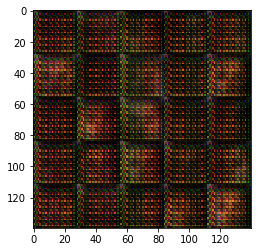

Epoch 1 of 1 Batch 110 Discriminator Loss: 0.6729740500450134 Generator Loss: 2.4058899879455566
Epoch 1 of 1 Batch 120 Discriminator Loss: 0.6834061145782471 Generator Loss: 2.062582492828369
Epoch 1 of 1 Batch 130 Discriminator Loss: 0.7038930654525757 Generator Loss: 2.0746707916259766
Epoch 1 of 1 Batch 140 Discriminator Loss: 0.6772356033325195 Generator Loss: 2.4662601947784424
Epoch 1 of 1 Batch 150 Discriminator Loss: 0.6908116340637207 Generator Loss: 2.1826162338256836
Epoch 1 of 1 Batch 160 Discriminator Loss: 0.6692543625831604 Generator Loss: 2.1271753311157227
Epoch 1 of 1 Batch 170 Discriminator Loss: 0.806962251663208 Generator Loss: 3.382200241088867
Epoch 1 of 1 Batch 180 Discriminator Loss: 0.6990747451782227 Generator Loss: 2.057915687561035
Epoch 1 of 1 Batch 190 Discriminator Loss: 0.6541708111763 Generator Loss: 2.2235560417175293
Epoch 1 of 1 Batch 200 Discriminator Loss: 0.6804741024971008 Generator Loss: 2.168046712875366


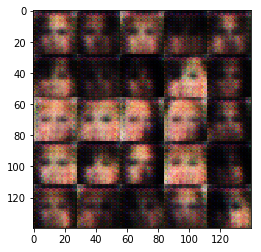

Epoch 1 of 1 Batch 210 Discriminator Loss: 0.6717522740364075 Generator Loss: 2.5359370708465576
Epoch 1 of 1 Batch 220 Discriminator Loss: 0.6767827868461609 Generator Loss: 2.2454166412353516
Epoch 1 of 1 Batch 230 Discriminator Loss: 0.6769940853118896 Generator Loss: 2.2324576377868652
Epoch 1 of 1 Batch 240 Discriminator Loss: 0.6875994205474854 Generator Loss: 2.2689356803894043
Epoch 1 of 1 Batch 250 Discriminator Loss: 0.6651096343994141 Generator Loss: 2.1845908164978027
Epoch 1 of 1 Batch 260 Discriminator Loss: 0.6866687536239624 Generator Loss: 2.168114423751831
Epoch 1 of 1 Batch 270 Discriminator Loss: 0.6651506423950195 Generator Loss: 2.451931953430176
Epoch 1 of 1 Batch 280 Discriminator Loss: 0.6635517477989197 Generator Loss: 2.3225858211517334
Epoch 1 of 1 Batch 290 Discriminator Loss: 0.6906344294548035 Generator Loss: 2.1922311782836914
Epoch 1 of 1 Batch 300 Discriminator Loss: 0.6664684414863586 Generator Loss: 2.326829433441162


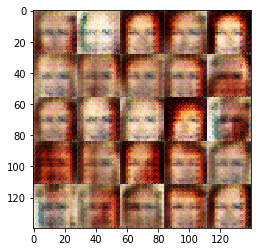

Epoch 1 of 1 Batch 310 Discriminator Loss: 0.6991082429885864 Generator Loss: 2.1256790161132812
Epoch 1 of 1 Batch 320 Discriminator Loss: 0.668341875076294 Generator Loss: 2.3539366722106934
Epoch 1 of 1 Batch 330 Discriminator Loss: 0.6548988223075867 Generator Loss: 2.2921183109283447
Epoch 1 of 1 Batch 340 Discriminator Loss: 0.6767698526382446 Generator Loss: 2.168015480041504
Epoch 1 of 1 Batch 350 Discriminator Loss: 0.6534270644187927 Generator Loss: 2.315173864364624
Epoch 1 of 1 Batch 360 Discriminator Loss: 0.6431741714477539 Generator Loss: 2.312541961669922
Epoch 1 of 1 Batch 370 Discriminator Loss: 0.6852059960365295 Generator Loss: 2.1325671672821045
Epoch 1 of 1 Batch 380 Discriminator Loss: 0.6510376930236816 Generator Loss: 2.3304450511932373
Epoch 1 of 1 Batch 390 Discriminator Loss: 0.6588333249092102 Generator Loss: 2.4581243991851807
Epoch 1 of 1 Batch 400 Discriminator Loss: 0.66669762134552 Generator Loss: 2.173433303833008


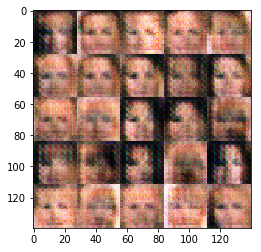

Epoch 1 of 1 Batch 410 Discriminator Loss: 0.6637389659881592 Generator Loss: 2.322695732116699
Epoch 1 of 1 Batch 420 Discriminator Loss: 0.6567005515098572 Generator Loss: 2.3946242332458496
Epoch 1 of 1 Batch 430 Discriminator Loss: 0.6720259189605713 Generator Loss: 2.252110242843628
Epoch 1 of 1 Batch 440 Discriminator Loss: 0.6582105755805969 Generator Loss: 2.2122952938079834
Epoch 1 of 1 Batch 450 Discriminator Loss: 0.6436949968338013 Generator Loss: 2.279341459274292
Epoch 1 of 1 Batch 460 Discriminator Loss: 0.6776719093322754 Generator Loss: 2.077371835708618
Epoch 1 of 1 Batch 470 Discriminator Loss: 0.6511771082878113 Generator Loss: 2.521782159805298
Epoch 1 of 1 Batch 480 Discriminator Loss: 0.6718870401382446 Generator Loss: 2.16658878326416
Epoch 1 of 1 Batch 490 Discriminator Loss: 0.6573249101638794 Generator Loss: 2.3025319576263428
Epoch 1 of 1 Batch 500 Discriminator Loss: 0.6451771855354309 Generator Loss: 2.37431263923645


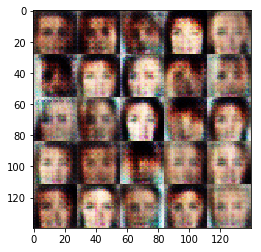

Epoch 1 of 1 Batch 510 Discriminator Loss: 0.673622190952301 Generator Loss: 2.444338798522949
Epoch 1 of 1 Batch 520 Discriminator Loss: 0.6478992700576782 Generator Loss: 2.336240530014038
Epoch 1 of 1 Batch 530 Discriminator Loss: 0.6655980348587036 Generator Loss: 2.1795849800109863
Epoch 1 of 1 Batch 540 Discriminator Loss: 0.6589721441268921 Generator Loss: 2.377113103866577
Epoch 1 of 1 Batch 550 Discriminator Loss: 0.6786726117134094 Generator Loss: 2.281414031982422
Epoch 1 of 1 Batch 560 Discriminator Loss: 0.6625901460647583 Generator Loss: 2.288353204727173
Epoch 1 of 1 Batch 570 Discriminator Loss: 0.6711094975471497 Generator Loss: 2.2354676723480225
Epoch 1 of 1 Batch 580 Discriminator Loss: 0.6575896739959717 Generator Loss: 2.2764086723327637
Epoch 1 of 1 Batch 590 Discriminator Loss: 0.6691852807998657 Generator Loss: 2.2832417488098145
Epoch 1 of 1 Batch 600 Discriminator Loss: 0.6568105816841125 Generator Loss: 2.248772382736206


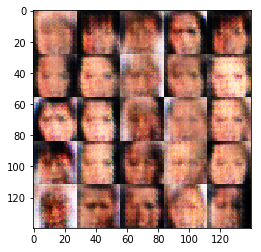

Epoch 1 of 1 Batch 610 Discriminator Loss: 0.6492689847946167 Generator Loss: 2.345644474029541
Epoch 1 of 1 Batch 620 Discriminator Loss: 0.6586222052574158 Generator Loss: 2.281261920928955
Epoch 1 of 1 Batch 630 Discriminator Loss: 0.6465290784835815 Generator Loss: 2.314030408859253
Epoch 1 of 1 Batch 640 Discriminator Loss: 0.6686139702796936 Generator Loss: 2.2743260860443115
Epoch 1 of 1 Batch 650 Discriminator Loss: 0.6578292846679688 Generator Loss: 2.336073398590088
Epoch 1 of 1 Batch 660 Discriminator Loss: 0.6534021496772766 Generator Loss: 2.3929426670074463
Epoch 1 of 1 Batch 670 Discriminator Loss: 0.6691223978996277 Generator Loss: 2.2567574977874756
Epoch 1 of 1 Batch 680 Discriminator Loss: 0.6885228753089905 Generator Loss: 2.5408365726470947
Epoch 1 of 1 Batch 690 Discriminator Loss: 0.6571140289306641 Generator Loss: 2.238703966140747
Epoch 1 of 1 Batch 700 Discriminator Loss: 0.6579071283340454 Generator Loss: 2.227513313293457


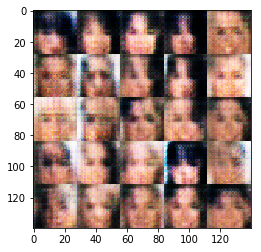

Epoch 1 of 1 Batch 710 Discriminator Loss: 0.6699461340904236 Generator Loss: 2.2269153594970703
Epoch 1 of 1 Batch 720 Discriminator Loss: 0.6621085405349731 Generator Loss: 2.3455920219421387
Epoch 1 of 1 Batch 730 Discriminator Loss: 0.644821047782898 Generator Loss: 2.266169548034668
Epoch 1 of 1 Batch 740 Discriminator Loss: 0.675085723400116 Generator Loss: 2.2082631587982178
Epoch 1 of 1 Batch 750 Discriminator Loss: 0.6497495770454407 Generator Loss: 2.3630824089050293
Epoch 1 of 1 Batch 760 Discriminator Loss: 0.6596858501434326 Generator Loss: 2.2636566162109375
Epoch 1 of 1 Batch 770 Discriminator Loss: 0.6538110375404358 Generator Loss: 2.2130513191223145
Epoch 1 of 1 Batch 780 Discriminator Loss: 0.6647518873214722 Generator Loss: 2.199143886566162
Epoch 1 of 1 Batch 790 Discriminator Loss: 0.6619312763214111 Generator Loss: 2.3311243057250977
Epoch 1 of 1 Batch 800 Discriminator Loss: 0.6519253849983215 Generator Loss: 2.318493604660034


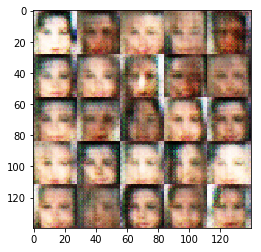

Epoch 1 of 1 Batch 810 Discriminator Loss: 0.6598737835884094 Generator Loss: 2.2585537433624268
Epoch 1 of 1 Batch 820 Discriminator Loss: 0.6641395092010498 Generator Loss: 2.2236292362213135
Epoch 1 of 1 Batch 830 Discriminator Loss: 0.6636350154876709 Generator Loss: 2.447190523147583
Epoch 1 of 1 Batch 840 Discriminator Loss: 0.6545366644859314 Generator Loss: 2.2147886753082275
Epoch 1 of 1 Batch 850 Discriminator Loss: 0.6616883277893066 Generator Loss: 2.0842983722686768
Epoch 1 of 1 Batch 860 Discriminator Loss: 0.6468779444694519 Generator Loss: 2.1794095039367676
Epoch 1 of 1 Batch 870 Discriminator Loss: 0.6723207831382751 Generator Loss: 2.392442226409912
Epoch 1 of 1 Batch 880 Discriminator Loss: 0.6627039313316345 Generator Loss: 2.196725368499756
Epoch 1 of 1 Batch 890 Discriminator Loss: 0.6614477038383484 Generator Loss: 2.2311995029449463
Epoch 1 of 1 Batch 900 Discriminator Loss: 0.6633617877960205 Generator Loss: 2.1221344470977783


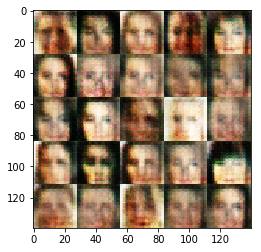

Epoch 1 of 1 Batch 910 Discriminator Loss: 0.6458754539489746 Generator Loss: 2.316953420639038
Epoch 1 of 1 Batch 920 Discriminator Loss: 0.6542797088623047 Generator Loss: 2.5933642387390137
Epoch 1 of 1 Batch 930 Discriminator Loss: 0.6615844964981079 Generator Loss: 2.4800684452056885
Epoch 1 of 1 Batch 940 Discriminator Loss: 0.6530724763870239 Generator Loss: 2.474907398223877
Epoch 1 of 1 Batch 950 Discriminator Loss: 0.6744892001152039 Generator Loss: 2.514237642288208
Epoch 1 of 1 Batch 960 Discriminator Loss: 0.6646574139595032 Generator Loss: 2.3676791191101074
Epoch 1 of 1 Batch 970 Discriminator Loss: 0.6574610471725464 Generator Loss: 2.2668933868408203
Epoch 1 of 1 Batch 980 Discriminator Loss: 0.6777538657188416 Generator Loss: 2.4574060440063477
Epoch 1 of 1 Batch 990 Discriminator Loss: 0.6479127407073975 Generator Loss: 2.3426008224487305
Epoch 1 of 1 Batch 1000 Discriminator Loss: 0.6563467979431152 Generator Loss: 2.131842613220215


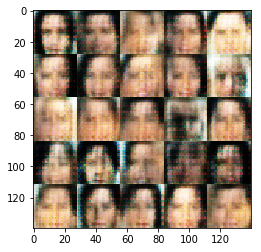

Epoch 1 of 1 Batch 1010 Discriminator Loss: 0.6544721126556396 Generator Loss: 2.2346043586730957
Epoch 1 of 1 Batch 1020 Discriminator Loss: 0.6552333831787109 Generator Loss: 2.3663992881774902
Epoch 1 of 1 Batch 1030 Discriminator Loss: 0.6527319550514221 Generator Loss: 2.316300868988037
Epoch 1 of 1 Batch 1040 Discriminator Loss: 0.6459506154060364 Generator Loss: 2.347749710083008
Epoch 1 of 1 Batch 1050 Discriminator Loss: 0.6569226980209351 Generator Loss: 2.0854859352111816
Epoch 1 of 1 Batch 1060 Discriminator Loss: 0.6545241475105286 Generator Loss: 2.324927806854248
Epoch 1 of 1 Batch 1070 Discriminator Loss: 0.6418826580047607 Generator Loss: 2.2529397010803223
Epoch 1 of 1 Batch 1080 Discriminator Loss: 0.7334270477294922 Generator Loss: 1.8809478282928467
Epoch 1 of 1 Batch 1090 Discriminator Loss: 0.633729100227356 Generator Loss: 2.263018846511841
Epoch 1 of 1 Batch 1100 Discriminator Loss: 0.6575630307197571 Generator Loss: 2.2214131355285645


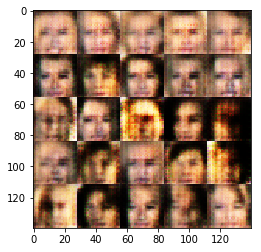

Epoch 1 of 1 Batch 1110 Discriminator Loss: 0.6656050682067871 Generator Loss: 2.7539546489715576
Epoch 1 of 1 Batch 1120 Discriminator Loss: 0.6467444896697998 Generator Loss: 2.3670363426208496
Epoch 1 of 1 Batch 1130 Discriminator Loss: 0.6806588172912598 Generator Loss: 1.918226718902588
Epoch 1 of 1 Batch 1140 Discriminator Loss: 0.6559323668479919 Generator Loss: 2.1679821014404297
Epoch 1 of 1 Batch 1150 Discriminator Loss: 0.6555967926979065 Generator Loss: 2.3274879455566406
Epoch 1 of 1 Batch 1160 Discriminator Loss: 0.7092286348342896 Generator Loss: 1.93889582157135
Epoch 1 of 1 Batch 1170 Discriminator Loss: 0.6411623358726501 Generator Loss: 2.6613223552703857
Epoch 1 of 1 Batch 1180 Discriminator Loss: 0.663089394569397 Generator Loss: 2.2271976470947266
Epoch 1 of 1 Batch 1190 Discriminator Loss: 0.6607370376586914 Generator Loss: 2.547990560531616
Epoch 1 of 1 Batch 1200 Discriminator Loss: 0.6618984341621399 Generator Loss: 2.091094970703125


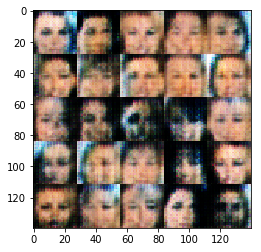

Epoch 1 of 1 Batch 1210 Discriminator Loss: 0.6348776817321777 Generator Loss: 2.4467363357543945
Epoch 1 of 1 Batch 1220 Discriminator Loss: 0.6352527737617493 Generator Loss: 2.703988552093506
Epoch 1 of 1 Batch 1230 Discriminator Loss: 0.7340801954269409 Generator Loss: 2.2116780281066895
Epoch 1 of 1 Batch 1240 Discriminator Loss: 0.6671149730682373 Generator Loss: 2.331251859664917
Epoch 1 of 1 Batch 1250 Discriminator Loss: 0.6536970138549805 Generator Loss: 2.262864589691162
Epoch 1 of 1 Batch 1260 Discriminator Loss: 0.6568852663040161 Generator Loss: 2.2641525268554688
Epoch 1 of 1 Batch 1270 Discriminator Loss: 0.6568377614021301 Generator Loss: 2.222759962081909
Epoch 1 of 1 Batch 1280 Discriminator Loss: 0.670335590839386 Generator Loss: 2.2098169326782227
Epoch 1 of 1 Batch 1290 Discriminator Loss: 0.6585529446601868 Generator Loss: 2.7173609733581543
Epoch 1 of 1 Batch 1300 Discriminator Loss: 0.6529101729393005 Generator Loss: 2.1409153938293457


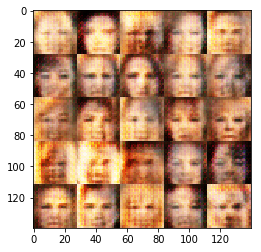

Epoch 1 of 1 Batch 1310 Discriminator Loss: 0.7145596146583557 Generator Loss: 1.7166297435760498
Epoch 1 of 1 Batch 1320 Discriminator Loss: 0.6570374965667725 Generator Loss: 2.299999475479126
Epoch 1 of 1 Batch 1330 Discriminator Loss: 0.6427565813064575 Generator Loss: 2.289883613586426
Epoch 1 of 1 Batch 1340 Discriminator Loss: 0.6543243527412415 Generator Loss: 2.2796542644500732
Epoch 1 of 1 Batch 1350 Discriminator Loss: 0.6563149094581604 Generator Loss: 2.2124481201171875
Epoch 1 of 1 Batch 1360 Discriminator Loss: 0.6683451533317566 Generator Loss: 2.3385276794433594
Epoch 1 of 1 Batch 1370 Discriminator Loss: 0.6593976020812988 Generator Loss: 2.3495678901672363
Epoch 1 of 1 Batch 1380 Discriminator Loss: 0.6568160057067871 Generator Loss: 2.2680132389068604
Epoch 1 of 1 Batch 1390 Discriminator Loss: 0.6480640769004822 Generator Loss: 2.349714994430542
Epoch 1 of 1 Batch 1400 Discriminator Loss: 0.6413064002990723 Generator Loss: 2.427471876144409


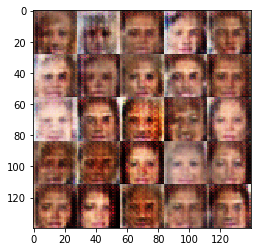

Epoch 1 of 1 Batch 1410 Discriminator Loss: 0.679405927658081 Generator Loss: 2.00262451171875
Epoch 1 of 1 Batch 1420 Discriminator Loss: 0.6434239745140076 Generator Loss: 2.373002529144287
Epoch 1 of 1 Batch 1430 Discriminator Loss: 0.6483967304229736 Generator Loss: 2.3048505783081055
Epoch 1 of 1 Batch 1440 Discriminator Loss: 0.6432201266288757 Generator Loss: 2.365212917327881
Epoch 1 of 1 Batch 1450 Discriminator Loss: 0.6532542705535889 Generator Loss: 2.3430380821228027
Epoch 1 of 1 Batch 1460 Discriminator Loss: 0.6462687849998474 Generator Loss: 2.587123155593872
Epoch 1 of 1 Batch 1470 Discriminator Loss: 0.6508909463882446 Generator Loss: 2.297635555267334
Epoch 1 of 1 Batch 1480 Discriminator Loss: 0.6486459970474243 Generator Loss: 2.273897409439087
Epoch 1 of 1 Batch 1490 Discriminator Loss: 0.6553921699523926 Generator Loss: 2.2648181915283203
Epoch 1 of 1 Batch 1500 Discriminator Loss: 0.6726089119911194 Generator Loss: 2.117157459259033


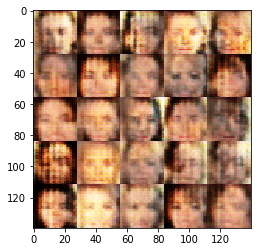

Epoch 1 of 1 Batch 1510 Discriminator Loss: 0.6321617364883423 Generator Loss: 2.385983943939209
Epoch 1 of 1 Batch 1520 Discriminator Loss: 0.6604904532432556 Generator Loss: 2.289437770843506
Epoch 1 of 1 Batch 1530 Discriminator Loss: 0.6467533707618713 Generator Loss: 2.308840751647949
Epoch 1 of 1 Batch 1540 Discriminator Loss: 0.670723557472229 Generator Loss: 2.1058945655822754
Epoch 1 of 1 Batch 1550 Discriminator Loss: 0.6611942648887634 Generator Loss: 2.605210781097412
Epoch 1 of 1 Batch 1560 Discriminator Loss: 0.6521243453025818 Generator Loss: 2.2821922302246094
Epoch 1 of 1 Batch 1570 Discriminator Loss: 0.6559373736381531 Generator Loss: 2.288494825363159
Epoch 1 of 1 Batch 1580 Discriminator Loss: 0.6518555879592896 Generator Loss: 2.3073408603668213


In [34]:
batch_size = 128 
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

## Referencies

https://github.com/Piasy/Udacity-DLND/tree/master/face-generation  </br>
https://github.com/BenGoBlue05/face-generation </br>
https://github.com/CtheSky/udacity-face-generation </br>


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.